<a href="https://colab.research.google.com/github/Hamid-Mofidi/PNP/blob/main/Bifurcation_of_lambda/bif_of_lam_new4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
fixed_r = 2
k = 1 # k=1: bif of lambda_1,  k=2: bif of lambda_2


In [2]:
def equations(x):
    A, I, V, l = x

    # k = 1
    r =  fixed_r
    eps = 1e-15 #  a small number

    sqA    = np.sqrt(1+A**2)
    sqB    = np.sqrt(1+(l-A+r)**2) #assume that alpha=1/3, beta=2/3
    logAB  = np.log(np.maximum( (l-A+r)*(sqA-1), eps)/np.maximum( A*(sqB-1), eps) )
    rho    = (A-l)**2 + (sqA - sqB)*(A-l)
    sigma  = l/r
    logSBA = np.log(np.maximum( sigma*(l-A+r) , eps)/ np.maximum(A, eps) ) # not a real number
    siglog = 3*sigma*np.log( np.maximum( sigma, eps) )/(l*(sigma-1))

    numI1   = (( (-1)**(k+1) )*siglog) * (A-l)**2
    numI2   = (logAB - ((-1)**k) * np.log( np.maximum(sigma, eps) ))*(A-l+eps)
    gamma1  = 1/(I-(A-l) * sqA)
    gamma2  = 1/(I-(A-l) * sqB)
    M       = I * (gamma2 - gamma1)+ rho/I
    ABGamma = A * gamma1 + (l-A+r) * gamma2
    ABGammaR= (1/A) * gamma1 + (1/(l-A+r)) * gamma2
    G41     = ( 1- (A-l)*ABGamma )*( logSBA + (A-l) * siglog )
    G42     = ( 1- (A-l)*ABGamma )* M
    G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
    GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR



    f1 = rho - (I* ( np.log( np.maximum( I-(A-l)*sqB, eps) /np.maximum( I-(A-l)*sqA , eps) )  ))
    f2 = V - logAB + ((I*logSBA-rho)/(A-l))
    f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )
    f4 = G41 - G42 + G43 - GR

    return [f1, f2, f3, f4]



In [3]:
num_pts = 10
A_range = np.linspace(0.01, 10, num_pts)
I_range = np.linspace(-60, 60, num_pts)
V_range = np.linspace(-80, 80, num_pts)
l_range = np.linspace(0.01, 10, num_pts)

r = fixed_r
print(r)

# Create a boolean mask for the constraint
# The resulting arrays for A_range, I_range, V_range, and L_range
# will only contain values that satisfy the constraint.
# Calculate Am
Am = l_range + r

# Calculate the expressions
expression1 = (A_range - l_range) * np.sqrt(1 + A_range**2)
expression2 = (A_range - l_range) * np.sqrt(1 + (l_range - A_range + r)**2)

# Calculate the maximum and minimum expressions
max_expression = np.maximum(expression1, expression2)
min_expression = np.minimum(expression1, expression2)

eps = 1e-15 #  a small number
#mask = ( (I_range > max_expression) | (I_range < min_expression) ) &\
#(np.abs(I_range) > eps) & (A_range > 0) & (np.abs(l_range-r) > eps) &\
#(l_range > 0)

#A_range = A_range[mask]
#I_range = I_range[mask]
#V_range = V_range[mask]
#l_range = l_range[mask]

# initialize arrays to store solutions
A_sol = []
I_sol = []
V_sol = []
l_sol = []

# Count the total number of iterations
total_iterations = len(A_range) * len(I_range) * len(l_range)

# Initialize tqdm
pbar = tqdm(total=total_iterations, mininterval=0.1)



import time

# Start the timer
start_time = time.time()

# loop through all combinations of initial values
for a in A_range:
    for i in I_range:
        for v in V_range:
            for ll in l_range:
                x0 = [a, i, v, ll]
                #def root_function(var):
                #    return equations([a, i, var, ll])
                # Solve for the variable component only
                #sol = root(root_function, x0[2], method='hybr')
                sol = root(equations, x0, method='hybr')
                # Calculate lmd1 and lmd2

                if sol.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression12 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + sol.x[0]**2)
                    expression22 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + (sol.x[3] - sol.x[0] + r)**2)
                    max_expression2 = np.maximum(expression12, expression22)
                    min_expression2 = np.minimum(expression12, expression22)

                    lmd1_sol = 3*(sol.x[3] - sol.x[0] + sol.x[1]) * \
                     (np.log(np.maximum(sol.x[3]/r, 1e-15))) / \
                     ((sol.x[3] - r) * (sol.x[2] +  np.log(sol.x[3]) - np.log(r)  ))

                    lmd2_sol = 3*(sol.x[3] - sol.x[0] - sol.x[1]) * \
                    (np.log(sol.x[3]) - np.log(r)) / \
                       ((sol.x[3] - r) * (-sol.x[2] + np.log(sol.x[3]) - np.log(r)  ))

                    mask2 =  ( (sol.x[1] > max_expression2) | (sol.x[1] < min_expression2) ) &\
                    (np.abs(sol.x[1]) > eps) & (sol.x[0] > 0) &  (np.abs(sol.x[3]-r) > eps)   &\
                    (sol.x[3] > 0) & (sol.x[0] < 0.5 * (sol.x[3] +r) )
                    if np.all(mask2): # only append if all elements of mask are True
                      A_sol = np.append(A_sol, sol.x[0])
                      I_sol = np.append(I_sol, sol.x[1])
                      V_sol = np.append(V_sol, sol.x[2])
                      l_sol = np.append(l_sol, sol.x[3])
                

                      # Update tqdm progress
                      pbar.update(1)
    pbar.update(1)
# Close tqdm
pbar.close()

2


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_300/2700243248.py:25: RuntimeWarning: invalid value encountered in scalar divide
  G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
/tmp/ipykernel_300/2700243248.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
/tmp/ipykernel_300/2700243248.py:26: RuntimeWarning: invalid value encountered in scalar multiply
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
/tmp/ipykernel_300/2700243248.py:31: RuntimeWarning: invalid value encountered in scalar divide
  f2 = V - logAB + ((I*logSBA-rho)/(A-l))
/tmp/ipykernel_300/2700243248.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )
 57%|█████▋    | 572/1000 [00:13<00:25, 17.08it/s] /tmp/ipykernel_300/3533175431.py:75: RuntimeWarning: invalid value encountered in log
  ((sol.x[3] - r) * (sol.x[2] +  np.log(sol.x[3]) - np.log(r)  ))
/tm

In [4]:
r = fixed_r
print('The right boundary concentration r is: ', r)
print(r'The solutions are based on the bifurcation of $\lambda_{k}$ where $k$ is:', k)

The right boundary concentration r is:  2
The solutions are based on the bifurcation of $\lambda_{k}$ where $k$ is: 1


In [5]:
# Calculate the time passing
end_time = time.time()
time_passing = end_time - start_time
print("Time passing:", time_passing, "seconds")

Time passing: 135.78216004371643 seconds


In [6]:

print(np.shape(A_sol))
#print('A[0:num_pts] = ', A_sol[0:])
print('min(A) =',np.min(A_sol))
print('max(A) =',np.max(A_sol))
#print('The second max of A is =',np.partition(A_sol,-50)[-50:-40])
print('type of A is', type(A_sol))

print(np.shape(l_sol))
#print('l[0:num_pts] = ', l_sol[0:])
print('min(l) =',np.min(l_sol))
print('max(l) =',np.max(l_sol))
#print('The second max of l is =',np.partition(l_sol,-550)[-550:-520])
print('type of l is', type(l_sol))

print(np.shape(V_sol))
#print('V[0:10] = ', V_sol[0:])
print('min(V) =',np.min(V_sol))
print('max(V) =',np.max(V_sol))
#print('The second max of V is =',np.partition(V_sol,-50)[-50:-40])
print('type of V is', type(V_sol))

print(np.shape(I_sol))
#print('I[0:10] = ', I_sol[0:])
print('min(I) =',np.min(I_sol))
print('max(I) =',np.max(I_sol))
#print('The second max of I is =',np.partition(I_sol,-50)[-50:-40])




(1055,)
min(A) = 0.002500423288489742
max(A) = 2.0000002162062054
type of A is <class 'numpy.ndarray'>
(1055,)
min(l) = 0.0025004229952925844
max(l) = 2.000001318746581
type of l is <class 'numpy.ndarray'>
(1055,)
min(V) = -246.260888872367
max(V) = 197.2542574377907
type of V is <class 'numpy.ndarray'>
(1055,)
min(I) = -82.7951201463123
max(I) = 63.47833158110566


In [7]:
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

#fig = plt.figure(figsize=(8, 6))
#ax = fig.add_subplot(111, projection='3d')

#ax.scatter(l_sol, V_sol, I_sol, c='red', s=5)
#ax.set_xlabel('l')
#ax.set_ylabel('V')
#ax.set_zlabel('I(current)')
#ax.set_xlim(0, 6)
#ax.set_ylim(-20, 50)
#ax.set_zlim(ymin, ymax)

#plt.show()


In [8]:

# Calculate lmd1 and lmd2
lmd1 = 3*(l_sol - A_sol + I_sol) * \
       (np.log(np.maximum(l_sol/r, 1e-15))) / \
       ((l_sol - r) * ( V_sol + np.log(l_sol) - np.log(r)   ))

lmd2 = 3*(l_sol - A_sol - I_sol) * \
       (np.log(np.maximum(l_sol/r, 1e-15))) / \
       ((l_sol - r) * (-V_sol + np.log(l_sol) - np.log(r)   ))

J1 = (l_sol - A_sol + I_sol) /2
J2 = (l_sol - A_sol - I_sol) /2

# Generate t vector
t = np.arange(len(lmd1))

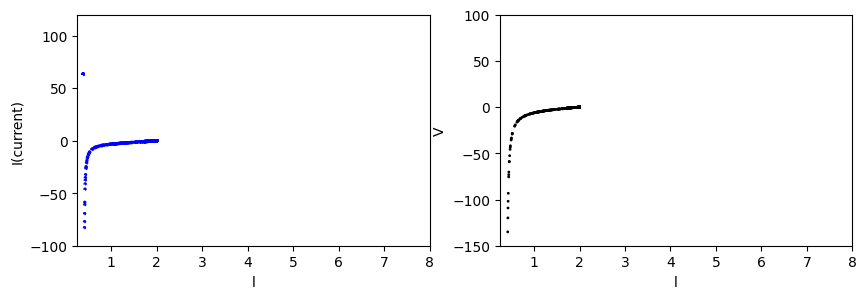

In [9]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)
axs[0, 0].scatter(l_sol, I_sol, s=2, c='blue', linestyle='--')
axs[0, 0].set_xlabel('l')
axs[0, 0].set_ylabel('I(current)')
axs[0,0].set_xlim(0.25, 8)  # Adjust the x-axis limits
axs[0,0].set_ylim(-100, 120)  # Adjust the y-axis limits

axs[0, 1].scatter(l_sol, V_sol, s=1, c='black', linestyle='-.')
axs[0, 1].set_xlabel('l')
axs[0, 1].set_ylabel('V')
axs[0,1].set_xlim(0.25, 8)  # Adjust the x-axis limits
axs[0,1].set_ylim(-150, 100)  # Adjust the y-axis limits


plt.show()

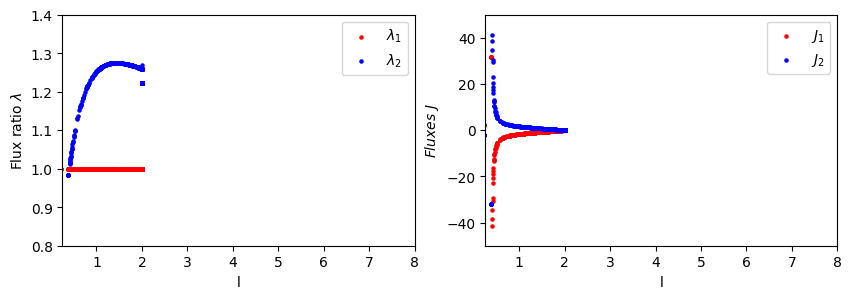

In [10]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(l_sol, lmd1, label='$\lambda_1$',s=5, color='red')
axs[0, 0].scatter(l_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].set_xlabel('l')
axs[0, 0].set_ylabel('Flux ratio $\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(0.25, 8)  # Adjust the x-axis limits
axs[0, 0].set_ylim(0.8, 1.4)  # Adjust the y-axis limits

axs[0, 1].scatter(l_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(l_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('l')
axs[0, 1].set_ylabel('$Fluxes~J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(.25, 8)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits


plt.show()

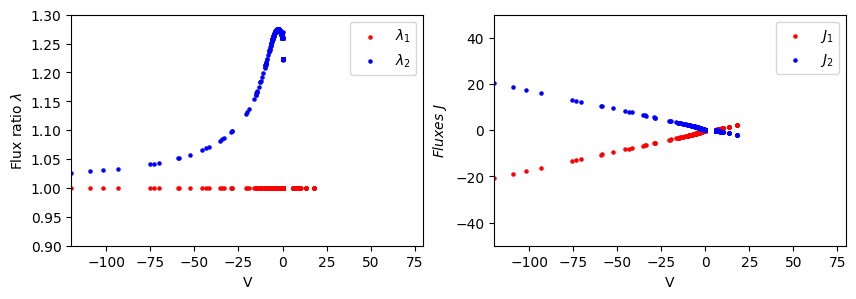

In [11]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(V_sol, lmd1, label='$\lambda_1$',s=5, color='red')
axs[0, 0].scatter(V_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('Flux ratio $\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-120, 80)  # Adjust the x-axis limits
axs[0, 0].set_ylim(0.9, 1.3)  # Adjust the y-axis limits

axs[0, 1].scatter(V_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(V_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('V')
axs[0, 1].set_ylabel('$Fluxes~J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-120, 80)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits


plt.show()

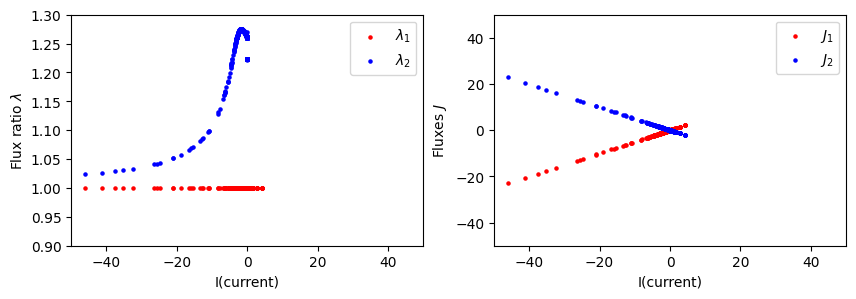

In [12]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(I_sol, lmd1, label='$\lambda_1$',s=5, color='red')
axs[0, 0].scatter(I_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].set_xlabel('I(current)')
axs[0, 0].set_ylabel('Flux ratio $\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-50, 50)  # Adjust the x-axis limits
axs[0, 0].set_ylim(.9, 1.3)  # Adjust the y-axis limits

axs[0, 1].scatter(I_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(I_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('I(current)')
axs[0, 1].set_ylabel('Fluxes $J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-50, 50)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits

plt.show()

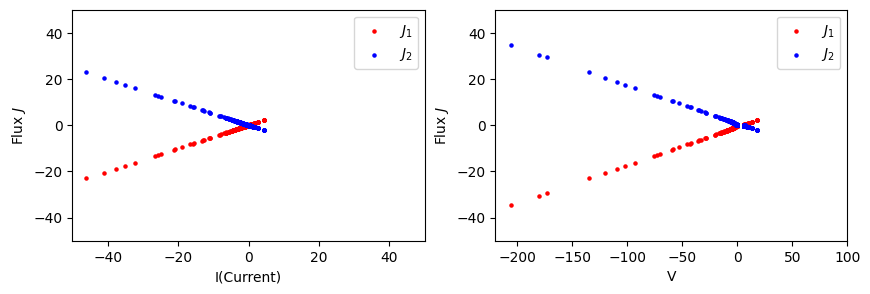

In [13]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(I_sol, J1, label='$J_1$',s=5, color='red')
axs[0, 0].scatter(I_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 0].set_xlabel('I(Current)')
axs[0, 0].set_ylabel('Flux $J$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-50, 50)  # Adjust the x-axis limits
axs[0, 0].set_ylim(-50, 50)  # Adjust the y-axis limits

axs[0, 1].scatter(V_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(V_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('V')
axs[0, 1].set_ylabel('Flux $J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-220, 100)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits

plt.show()

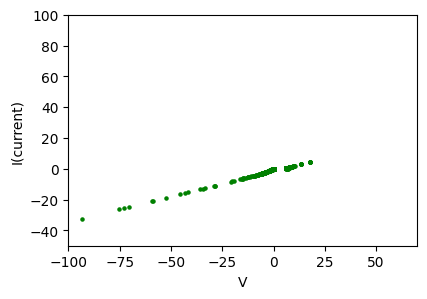

In [14]:
# plot the solutions
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3), squeeze=False)

axs[0, 0].scatter(V_sol, I_sol, s=5, c='green')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('I(current)')
axs[0, 0].set_xlim(-100, 70)  # Adjust the x-axis limits
axs[0, 0].set_ylim(-50, 100)  # Adjust the y-axis limits
# Plot lmd1 and lmd2 using scatter plots

plt.show()

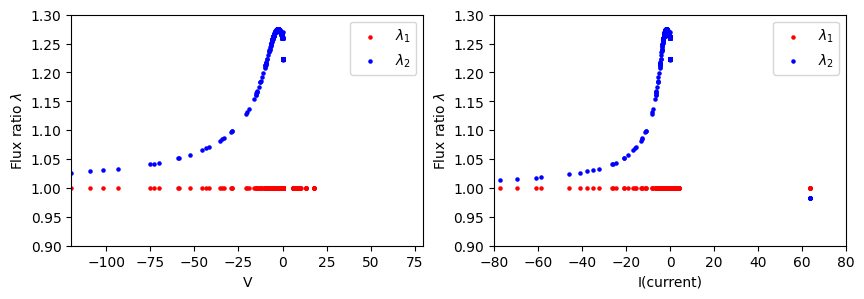

In [15]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(V_sol, lmd1, label='$\lambda_1$', s=5, color='red')
axs[0, 0].scatter(V_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('Flux ratio $\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-120, 80)  # Adjust the x-axis limits
axs[0, 0].set_ylim(.9, 1.3)  # Adjust the y-axis limits

axs[0, 1].scatter(I_sol, lmd1, label='$\lambda_1$', s=5, color='red')
axs[0, 1].scatter(I_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 1].set_xlabel('I(current)')
axs[0, 1].set_ylabel('Flux ratio $\lambda$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-80, 80)  # Adjust the x-axis limits
axs[0, 1].set_ylim(.9, 1.3)  # Adjust the y-axis limits
plt.show()